<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/06-Spatial_Data_and_Maps/A-Intro_to_Spatial_Data_US_census_tracts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Spatial Data: US census tracts and zipcodes

In [1]:
# @title Setup

!pip install -U -q geopandas tdqm folium mapclassify folium

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Change the graph defaults
plt.rcParams['figure.figsize'] = (8, 3)  # Default figure size of 6x2 inches
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['font.size'] = 10  # Default font size of 12 points
plt.rcParams['lines.linewidth'] = 1  # Default line width of 1 points
plt.rcParams['lines.markersize'] = 3  # Default marker size of 3 points
plt.rcParams['legend.fontsize'] = 10  # Default legend font size of 10 poin

## Types of Geographical Data and _Shapefiles_

When we deal with spatial data, we mainly deal with three general types of data:

* Points (e.g., lon/lat coordinates for a location)
* Lines (e.g., subway line)
* Polygons (e.g., borders of a country, state, zipcode etc)

From an analytics point of view, we are espeially interested in segmenting our data based on geography, and if possible also add additional information about the geographical area (e.g., population, average income etc).

There is a wide variety of geographical data available online. A big supplier of high-quality geographical data for the US is the US Census. They provide a complex geographical hierarchy, but at the basic level it is:

```
states > counties > tracts > blockgroups > blocks
```

The US Census tracts are roughly the size of zipcodes (in fact, a bit smaller, there are around 70K tracts and around 35K zipcodes in the US), and are a very common unit of statistical analysis. In fact, due to the carefulness in which US Census creates the tracts, to be as homogeneous as possible, it is a better geographical division that zipcodes.

## Examples of Geospatial Data offered by US Census

At data.gov you can find a [wide variety of geospatial data](https://catalog.data.gov/dataset/?metadata_type=geospatial). You may want to browse through some of the datasets.



## FIPS, States, and Counties

A good source of shapefiles for the US is the `TIGER` shapefiles offered by the US Census. For example, we can [get the shapes of all the US Counties](https://catalog.data.gov/dataset/tiger-line-shapefile-2019-nation-u-s-current-county-and-equivalent-national-shapefile).



In [2]:
counties_url = 'https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip'
counties_df = gpd.GeoDataFrame.from_file(counties_url)

In [3]:
counties_df = counties_df.filter ( ['GEOID', 'STATEFP', 'COUNTYFP', 'NAMELSAD', 'geometry'])

In [4]:
# GEOID is the primary key for the county.
# It is a combination of the STATEFP + COUNTYFP
# The STATEFP and COUNTYFP are standardized at the federal level
# and can be used widely to refer to states and counties (and more
# fine grained entries)
counties_df

,GEOID,STATEFP,COUNTYFP,NAMELSAD,geometry
0,31039,31,039,Cuming County,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53069,53,069,Wahkiakum County,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35011,35,011,De Baca County,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31109,31,109,Lancaster County,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31129,31,129,Nuckolls County,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."
...,...,...,...,...,...
3228,13123,13,123,Gilmer County,"POLYGON ((-84.65478 34.66559, -84.65488 34.669..."
3229,27135,27,135,Roseau County,"POLYGON ((-96.40466 48.80528, -96.40467 48.813..."
3230,28089,28,089,Madison County,"POLYGON ((-90.09363 32.70763, -90.09360 32.707..."
3231,48227,48,227,Howard County,"POLYGON ((-101.69227 32.27106, -101.69221 32.2..."


In [5]:
# Dropping non-continental states
counties_df = counties_df.query( "STATEFP!='02'" )  # Alaska
counties_df = counties_df.query( "STATEFP!='15'" ) # Hawaii
counties_df = counties_df.query( "STATEFP!='72'" ) # Puerto Rico
counties_df = counties_df.query( "STATEFP!='66'" ) # Guam
counties_df = counties_df.query( "STATEFP!='69'" ) # Commonwealth of the Northern Mariana Islands
counties_df = counties_df.query( "STATEFP!='60'" ) # American Samoa
counties_df = counties_df.query( "STATEFP!='78'" ) # United States Virgin Islands

<Axes: >

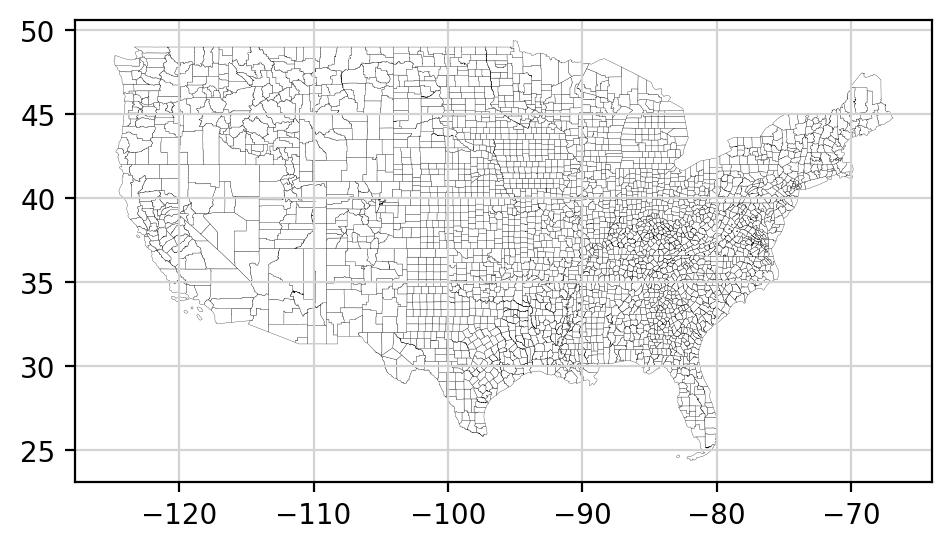

In [6]:
# Let's visualize with a static plot

counties_df.plot(
    color = 'white',
    edgecolor = 'black',
    linewidth=0.1,
    zorder=0,
    facecolor = 'white',
)

In [ ]:
# Now let's visualize with an interactive plot
# We limit ourselves to three states, otherwise it takes too long to load
(
    counties_df
    .query("STATEFP == '36' or STATEFP == '42' or STATEFP == '34' ")
    .explore(
        "NAMELSAD", # We use the "NAMELSAD" to color the counties
        cmap='tab20', # We use a non-ordered color map, for categorical data
        legend=False,
        style_kwds=dict(color="black", linewidth=0.3)
    )
)

### Example: Plotting Walkability Scores

Let's now use an example dataset from the EPA, the "walkability index". The Walkability Index dataset characterizes every Census 2019 **block group** in the US based on its relative walkability.

The example below will illustrate a general pattern for creating _choropleths_, a specific type of map visualization, where we color each area of interest with a color, to visualize a quantity of interest; in this case, we will visualize the walkability scores.

In [9]:
# First, we fetch the walkability dataset from EPA
walk = pd.read_csv('https://edg.epa.gov/EPADataCommons/public/OA/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv')

# A bit of bookkeeping: Making sure that the STATEFP/COUNTYFP retain their leading zeros
# and are not converted to integers.
walk.STATEFP = walk.STATEFP.astype(str).str.zfill(2)
walk.COUNTYFP = walk.COUNTYFP.astype(str).str.zfill(3)
walk.TRACTCE = walk.TRACTCE.astype(str).str.zfill(6)
walk.BLKGRPCE = walk.BLKGRPCE.astype(str)

# We make it easier to select counties based on a single column FIPS code instead of
# having separately STATEFP and COUNTYFP
walk['COUNTY_GEOID'] = walk.STATEFP.astype(str)  + walk.COUNTYFP.astype(str)

# Keep only a few of the columns in the dataset, we do not need the rest for this exercise
walk = walk.filter ( ['COUNTY_GEOID', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'NatWalkInd'])

<Axes: >

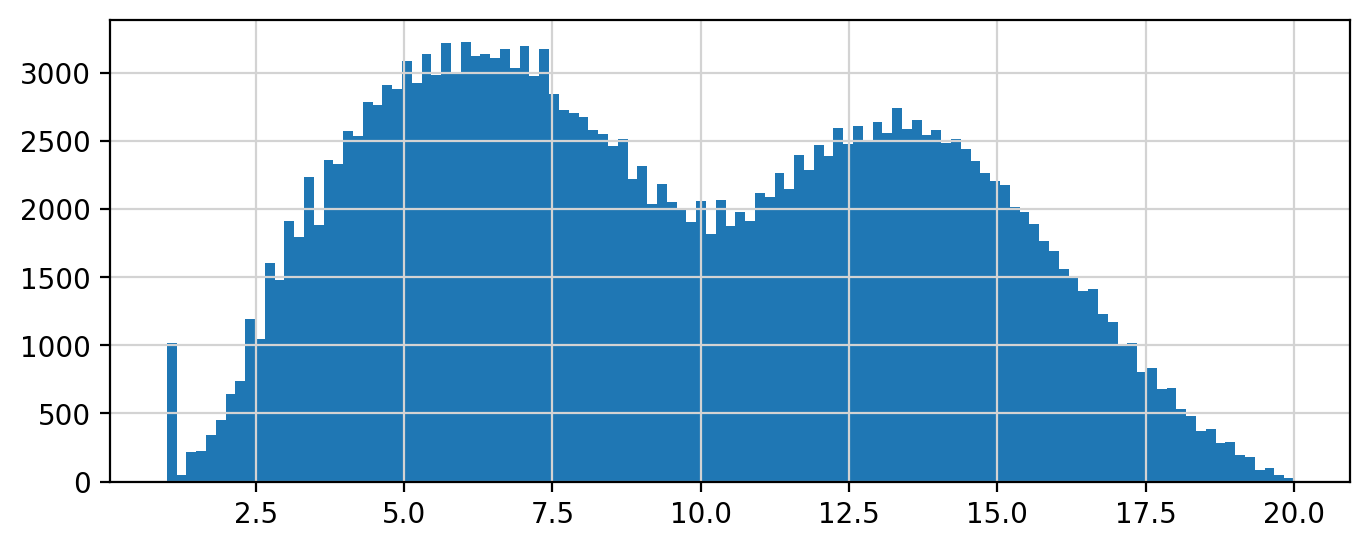

In [10]:
# Let's visualize the walkability score distribution across all 220K blockgroups
walk.NatWalkInd.hist(bins=115)

### Aggregate walkability scores on the county level

We have the data on a blockgroup level, but we want to calculate the score for counties. So we aggregate the scores across all blockgroups in a county.

In [11]:
# Now, let's calculate the average walkability score for each county.
# We will average across all blockgroups in that county.

county_walk_scores_mean = walk.pivot_table(
    index = 'COUNTY_GEOID',
    values = 'NatWalkInd',
    aggfunc = 'mean' #
)

county_walk_scores_mean

,NatWalkInd
COUNTY_GEOID,
01001,5.234375
01003,6.450355
01005,5.188406
01007,5.033333
01009,4.666667
...,...
72151,3.402778
72153,4.559524
78010,4.201550


In [ ]:
# @title (Optional) Alternative aggregation functions: Max & Mean of top-10%


county_walk_scores_max = walk.pivot_table(
    index = 'COUNTY_GEOID',
    values = 'NatWalkInd',
    aggfunc = 'max' # If we want to score each county based on its best score
)

# Calculates the mean across the top-10%
def top_10_percent_avg(series):
    threshold = np.ceil(len(series) * 0.1)  # Compute the number of entries for top 10%
    top_10_percent = series.nlargest(int(threshold))  # Get the top 10% values
    return top_10_percent.mean()  # Return their mean

county_walk_scores_mean10perc = walk.pivot_table(
    index = 'COUNTY_GEOID',
    values = 'NatWalkInd',
    aggfunc = top_10_percent_avg # Finds the top-10% of the blockgroups and calculates their average score
)

### Putting data together

In [18]:
# We now join the "geodataframe" counties_df, which contains the the shapes/geometries
# with the "walkability scores" and we keep at the end only the attributes that we need
gdf_scores = pd.merge(
    left = counties_df, # The geodataframe with the county shapes
    right = county_walk_scores_mean, # The walkability scores per county
    left_on="GEOID", # The id for the county in the geodataframe is GEOID
    right_index=True # The county code in the pivot table is in the index
).filter( ['GEOID', 'STATEFP', 'NAMELSAD',  'NatWalkInd', 'geometry']) # Keep only

gdf_scores

,GEOID,STATEFP,NAMELSAD,NatWalkInd,geometry
0,31039,31,Cuming County,7.395833,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53069,53,Wahkiakum County,4.533333,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35011,35,De Baca County,6.916667,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31109,31,Lancaster County,13.232172,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31129,31,Nuckolls County,6.266667,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."
...,...,...,...,...,...
3228,13123,13,Gilmer County,5.000000,"POLYGON ((-84.65478 34.66559, -84.65488 34.669..."
3229,27135,27,Roseau County,5.358974,"POLYGON ((-96.40466 48.80528, -96.40467 48.813..."
3230,28089,28,Madison County,6.608333,"POLYGON ((-90.09363 32.70763, -90.09360 32.707..."
3231,48227,48,Howard County,7.470238,"POLYGON ((-101.69227 32.27106, -101.69221 32.2..."


In [19]:
# Let's see the most walkable counties (on average)
gdf_scores.sort_values('NatWalkInd', ascending=False).head(10)

,GEOID,STATEFP,NAMELSAD,NatWalkInd,geometry
636,06075,06,San Francisco County,15.957258,"MULTIPOLYGON (((-122.61228 37.81522, -122.5845..."
712,51610,51,Falls Church city,15.812500,"POLYGON ((-77.19499 38.89846, -77.19499 38.898..."
1115,51600,51,Fairfax city,15.666667,"POLYGON ((-77.33485 38.85374, -77.33480 38.853..."
319,41051,41,Multnomah County,15.415547,"POLYGON ((-122.86749 45.60623, -122.86830 45.6..."
61,25025,25,Suffolk County,14.936791,"POLYGON ((-71.03318 42.41421, -71.03301 42.414..."
599,42101,42,Philadelphia County,14.833583,"POLYGON ((-75.28027 39.97496, -75.27951 39.975..."
1855,51678,51,Lexington city,14.666667,"POLYGON ((-79.46158 37.78636, -79.45943 37.788..."
1182,51660,51,Harrisonburg city,14.648148,"POLYGON ((-78.91787 38.39415, -78.91769 38.394..."
269,51510,51,Alexandria city,14.511006,"POLYGON ((-77.14436 38.81036, -77.14397 38.810..."
631,11001,11,District of Columbia,14.471481,"POLYGON ((-77.11975 38.93435, -77.11886 38.935..."


<Axes: >

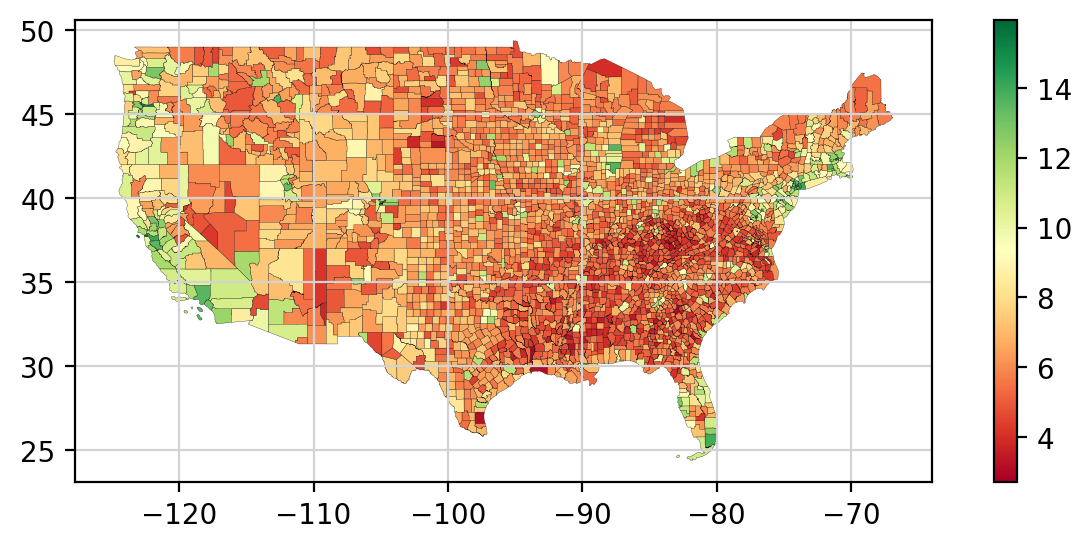

In [20]:
gdf_scores.plot(
    column = 'NatWalkInd', # Defines what column we will use for the visualization
    legend = True,
    cmap = 'RdYlGn', # This defines the color scheme
    edgecolor = 'black',
    linewidth=0.1,
)

<Axes: >

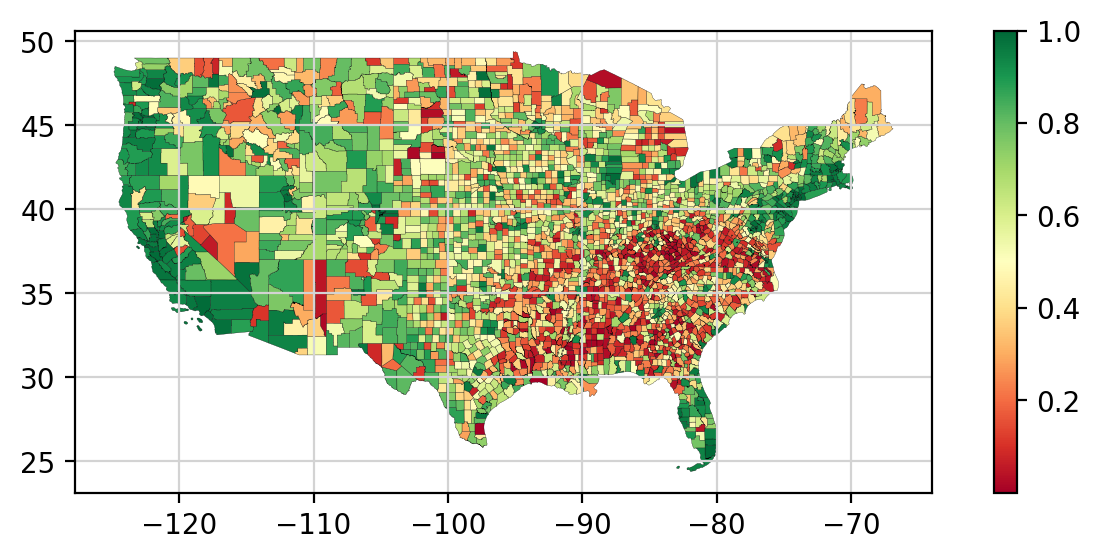

In [22]:
# When we use color scales to visualize a quantity, we often do not use the
# color space effectively, when the distribution of values is skewed.
# So, in many cases we covert the quantity into "percentiles" (or ranks)
# that are guaranteed to be uniformly distributed and allow all colors
# of the color scheme to be shown in the visualization.
gdf_scores["NatWalkInd_percentile"] = gdf_scores['NatWalkInd'].rank(pct=True)

gdf_scores.plot(
    column = 'NatWalkInd_percentile',
    legend = True,
    cmap = 'RdYlGn',
    edgecolor = 'black',
    linewidth=0.1,
)

In [ ]:
# Let's visualize with an interactive plot
(
    gdf_scores
    .query("STATEFP == '36' or STATEFP == '42' or STATEFP == '34' ")
    .explore(
        "NatWalkInd",
        cmap='RdYlGn',
        legend=False,
        style_kwds=dict(color="black", linewidth=0.3)
        )
)

## US Census Tracts




The US Census runs a yearly survey (the ACS survey) that collects a wide variety of detailed information about each census tract. [For example, consider the information about our own census tract](https://censusreporter.org/profiles/14000US36061005501-census-tract-5501-new-york-ny/): data about population, income, age, educational level, house values, renters vs owners, and many many other data points.

The file below contains the description of all the US Census tracts:

In [ ]:
!curl https://storage.googleapis.com/datasets_nyu/usa_tracts.zip -o usa_tracts.zip

In [ ]:
shapefile = f'usa_tracts.zip'
tracts_df = gpd.GeoDataFrame.from_file(shapefile)

# makes it easier to select counties based on their FIPS code
tracts_df.COUNTYFP = tracts_df.STATEFP.astype(str)  + tracts_df.COUNTYFP.astype(str)

In [ ]:
tracts_df

In [ ]:
# Dropping non-continental states
tracts_df = tracts_df[ tracts_df.STATEFP!='02' ]  # Alaska
tracts_df = tracts_df[ tracts_df.STATEFP!='15' ] # Hawaii
tracts_df = tracts_df[ tracts_df.STATEFP!='72' ] # Puerto Rico
tracts_df = tracts_df[ tracts_df.STATEFP!='66' ] # Guam
tracts_df = tracts_df[ tracts_df.STATEFP!='69' ] # Commonwealth of the Northern Mariana Islands
tracts_df = tracts_df[ tracts_df.STATEFP!='60' ] # American Samoa
tracts_df = tracts_df[ tracts_df.STATEFP!='78' ] # United States Virgin Islands

In [ ]:
tracts_df.plot(
    color = 'white',
    edgecolor = 'black',
    linewidth=0.1,
    zorder=0,
    facecolor = 'white',
)

## ZIP Codes

Often people ask why we do not use zipcodes instead of census tracts.

The answer is two-fold:

* The USPS does not release shapefiles of their zipcodes
* [The zip codes are not areas](https://manifold.net/doc/mfd9/zip_codes_are_not_areas.htm). In fact they are a bunch of delivery routes/lines, not areas.
* The US Census though releases the [ZIP Code Tabulation Areas (ZCTAs)](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html)



In [ ]:
!curl https://storage.googleapis.com/datasets_nyu/tl_2020_us_zcta510.zip -o tl_2020_us_zcta510.zip

In [ ]:
shapefile = f'tl_2020_us_zcta510.zip'
zipcodes_df = gpd.GeoDataFrame.from_file(shapefile)


In [ ]:
zipcodes_df

In [ ]:
zipcodes_df.plot(
    figsize=(20,20),
    color = 'white',
    edgecolor = 'black',
    linewidth=0.1,
    zorder=0,
    facecolor = 'white',
)